In [1]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import time
import wave
import IPython.display as ipd
import librosa.display
import sklearn
from scipy.stats import kurtosis, skew

class Audio():
    def __init__(self):
        super(Audio, self).__init__()
        
        self.SHORT_NORMALIZE = (1.0/32768.0)
        self.RATE = 44100  
        self.INPUT_BLOCK_TIME = 0.05
        self.CHUNK = int(self.RATE*self.INPUT_BLOCK_TIME)
        self.CHANNEL = 2
        
        self.microphone_name = "3- Andrea PureAudio"

    def initiate_mic(self):
        self.pa = pyaudio.PyAudio()
        device_index = self.discover_mic()  
        self.mic = self.pa.open(format = pyaudio.paInt16,
                    channels = self.CHANNEL,
                    rate =  self.RATE ,
                    input = True,
                    input_device_index = device_index,
                    frames_per_buffer = self.CHUNK
                    )
        
    def discover_mic(self):

        for i in range(self.pa.get_device_count() ):     
            devinfo = self.pa.get_device_info_by_index(i)   

            if self.microphone_name in devinfo["name"]:
                    device_index = i
                    return device_index

    def record_audio(self, filename, runtime):

        blocks = []

        print("Recording starts..")
        st = time.time()
        while True:
            block = self.mic.read(self.CHUNK)
            blocks.append(block)

            t = time.time() - st

            if t>runtime:        
                self.save_audio(filename, blocks)        
                self.close_mic()
                break

        print("Recording done! Saved as ", filename)

    def save_audio(self, filename, blocks):
        wf = wave.open(filename, 'wb')
        wf.setnchannels(self.CHANNEL)
        wf.setsampwidth(self.pa.get_sample_size(pyaudio.paInt16))
        wf.setframerate(self.RATE)
        wf.writeframes(b''.join(blocks))
        wf.close()

    def close_mic(self):
        self.mic.stop_stream()
        self.mic.close()
        self.pa.terminate()  
        
class Features():
    def __init__(self):
        super(Features, self).__init__()
        
    def load_file(self, filename):
        self.x, self.sr = librosa.load(filename)
        
        return self.x, self.sr
        
    def wave(self):
        return self.x
    
    def spec(self):
        X = librosa.stft(self.x)
        spec = librosa.amplitude_to_db(abs(X))        
        return spec
        
    def spectral_centroid(self):
        #spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
        spectral_centroids = librosa.feature.spectral_centroid(y=self.x, sr=self.sr)[0]
        # Computing the time variable for visualization
        frames = range(len(spectral_centroids))
        t = librosa.frames_to_time(frames)
        
        return spectral_centroids, t
             
    def spectral_rolloff(self): 
        spectral_centroids = librosa.feature.spectral_centroid(y=self.x, sr=self.sr)[0]
        # Computing the time variable for visualization
        frames = range(len(spectral_centroids))
        t = librosa.frames_to_time(frames)
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=self.x, sr=self.sr)[0]
        return spectral_rolloff, t
        
    def mfcc(self):
        #MFCC — Mel-Frequency Cepstral Coefficients
        mfccs = librosa.feature.mfcc(y=self.x, sr=self.sr)
        return mfccs
    
    def rms_energy(self):
        # Get RMS value from each frame's magnitude value
        S, phase = librosa.magphase(librosa.stft(self.x))
        rms = librosa.feature.rms(S=S)        
        return rms
    
    def chroma(self):
        hop_length = 512
        chromagram = librosa.feature.chroma_stft(y=self.x, sr=self.sr, hop_length=hop_length)        
        return chromagram
        
    def tempogram(self):
        hop_length = 512
        # Compute local onset autocorrelation
        oenv = librosa.onset.onset_strength(y=self.x, sr=self.sr, hop_length=hop_length)
        times = librosa.times_like(oenv, sr=self.sr, hop_length=hop_length)
        tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=self.sr,
                                              hop_length=hop_length)       
        return tempogram
    
    def miscellaneous(self):
        std = np.std(self.x)
        max = np.max(self.x)
        min = np.min(self.x)
        mean = np.mean(self.x)
        var = np.var(self.x)
        sk = skew(self.x)
        kurt = kurtosis(self.x)
        zx = sum(librosa.zero_crossings(self.x, pad=False))
        quantiles = np.quantile(self.x, [0.10, 0.25, 0.50, 0.75])
        
        return std, max, min, mean, var, sk, kurt, zx, quantiles
    
    
class Visualize():
    def __init__(self, x, sr, hop):
        super(Visualize, self).__init__()
        self.x = x
        self.sr = sr
        self.hop= hop
        
    def load_file(self, filename):
        self.x, self.sr = librosa.load(filename)
        
    def normalize(self, x, axis=0):
            return sklearn.preprocessing.minmax_scale(x, axis=axis)
        
    def show_wave(self):
        librosa.display.waveshow(self.x, sr = self.sr)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (scaled)")
        plt.title("Raw signal")
        
    def show_spec(self, Xdb):
        librosa.display.specshow(Xdb, sr=self.sr, x_axis='time', y_axis='hz') 
        plt.colorbar()
        plt.xlabel("Time (seconds)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Spectogram")
        
    def show_spectral_centroid(self, spectral_centroids, t):
        librosa.display.waveshow(self.x, sr=self.sr, alpha=0.4)
        plt.plot(t, self.normalize(spectral_centroids), color='r')
        plt.title("Spectral Centroid")
             
    def show_spectral_rolloff(self, spectral_rolloff, t): 
        librosa.display.waveshow(self.x, sr=self.sr, alpha=0.4)        
        plt.plot(t, self.normalize(spectral_rolloff), color='r')
        plt.title("Spectral Rolloff")
        
    def show_mfcc(self, mfccs):
        librosa.display.specshow(mfccs, sr=self.sr, x_axis='time')   
        plt.xlabel("Time (seconds)")
        plt.ylabel("Index")
        plt.title("MFCC")
    
    def show_rms_energy(self, rms):
        times = librosa.times_like(rms)
        plt.semilogy(times, rms[0], label='RMS Energy' )
        plt.legend()
        plt.title("RMS Energy")
    
    def show_chroma(self, chromagram):
        img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=self.hop, cmap='coolwarm')
        plt.colorbar(img)
        plt.title("Chroma")
        
    def show_tempogram(self, tempogram):
        librosa.display.specshow(tempogram, sr=self.sr, hop_length=self.hop,
                         x_axis='time', y_axis='tempo', cmap='magma') 
        plt.title("Tempogram")

## Record audio

In [ ]:
filename = "test.wav"
runtime = 5 #sec

audio = Audio()
audio.initiate_mic()
audio.record_audio(filename, runtime)
ipd.Audio(filename)

## Compute Features

In [3]:
filename = "test.wav"

feature = Features()
x, sr = feature.load_file(filename)
spec = feature.spec()
spec_centroid, t = feature.spectral_centroid()
spec_roll_off, t = feature.spectral_rolloff()
mfccs = feature.mfcc()
rms_energy = feature.rms_energy()
chroma = feature.chroma()
tempogram = feature.tempogram()
std, max, min, mean, var, sk, kurt, zx, quantiles = feature.miscellaneous()

print("Raw signal shape: ",x.shape)
print("Spectogram shape", spec.shape)
print("Spec centroid shape: ", spec_centroid.shape)
print("MFCC shape: ", mfccs.shape)
print("RMS energy shapeL ", rms_energy.shape)
print("Chroma shape: ", chroma.shape)
print("Tempogram shape: ", tempogram.shape)
print("Standard Daviation: ", std)
print("Max amplitude:", max)
print("Min amplitude: ", min)
print("Mean: ", mean)
print("Variance: ", var)
print("Skew: ", sk)
print("Kurtosis: ", kurt)
print("Zero crossings: ", zx)
print("Quantiles (10%):", quantiles[0])
print("Quantiles (25%):", quantiles[0])
print("Quantiles (50%):", quantiles[0])
print("Quantiles (75%):", quantiles[0])

Raw signal shape:  (110250,)
Spectogram shape (1025, 216)
Spec centroid shape:  (216,)
MFCC shape:  (20, 216)
RMS energy shapeL  (1, 216)
Chroma shape:  (12, 216)
Tempogram shape:  (384, 216)
Standard Daviation:  0.06950963
Max amplitude: 1.0120267
Min amplitude:  -1.016979
Mean:  0.0009368034
Variance:  0.004831589
Skew:  -2.570549472174507
Kurtosis:  37.37148163265329
Zero crossings:  1475
Quantiles (10%): -0.032177345827221863
Quantiles (25%): -0.032177345827221863
Quantiles (50%): -0.032177345827221863
Quantiles (75%): -0.032177345827221863


## Visualize features

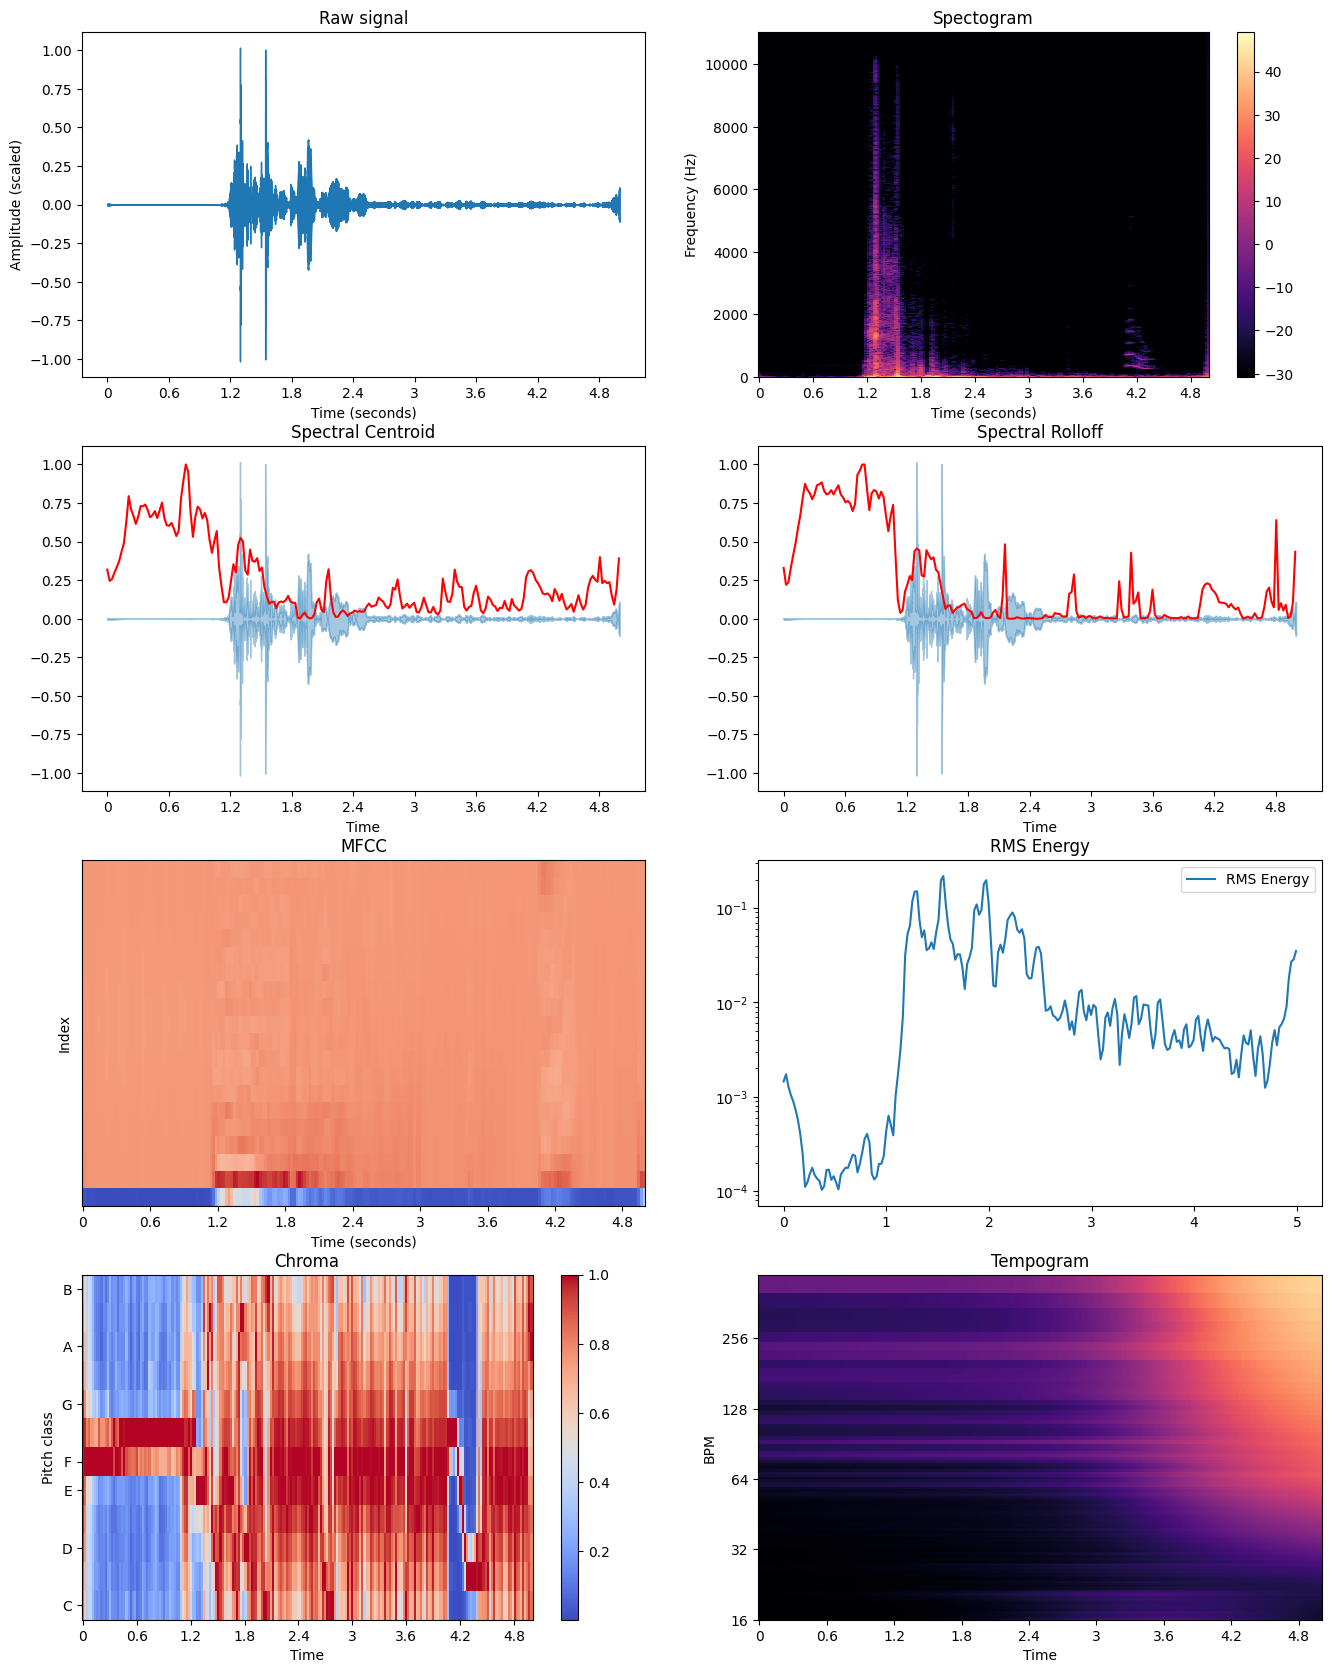

In [4]:
vis = Visualize(x, sr, hop=512)

plt.figure(figsize=(16, 26)) 
plt.subplot(5,2,1)
vis.show_wave()
plt.subplot(5,2,2)
vis.show_spec(spec)
plt.subplot(5,2,3)
vis.show_spectral_centroid(spec_centroid, t)
plt.subplot(5,2,4)
vis.show_spectral_rolloff(spec_roll_off, t)
plt.subplot(5,2,5)
vis.show_mfcc(mfccs)
plt.subplot(5,2,6)
vis.show_rms_energy(rms_energy)
plt.subplot(5,2,7)
vis.show_chroma(chroma)
plt.subplot(5,2,8)
vis.show_tempogram(tempogram)